In [37]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn models and metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
                             confusion_matrix, classification_report, roc_curve, auc,ConfusionMatrixDisplay)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import HistGradientBoostingClassifier

In [38]:
df = pd.read_csv(r'/content/bank-full.csv', sep=';')
print(f"Dataset Shape: {df.shape}")
print(df.head())

Dataset Shape: (45211, 17)
   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  


In [39]:
# Check Data Types
print("\nData Types:\n", df.dtypes)

# Check Unique Values
print("\nUnique values per column:\n")
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")

# Replace 'unknown' with NaN
df.replace('unknown', np.nan, inplace=True)


Data Types:
 age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

Unique values per column:

age: 77 unique values
job: 12 unique values
marital: 3 unique values
education: 4 unique values
default: 2 unique values
balance: 7168 unique values
housing: 2 unique values
loan: 2 unique values
contact: 3 unique values
day: 31 unique values
month: 12 unique values
duration: 1573 unique values
campaign: 48 unique values
pdays: 559 unique values
previous: 41 unique values
poutcome: 4 unique values
y: 2 unique values


In [40]:
# Fill missing categorical values logically (mode imputation)
for col in df.select_dtypes(include='object').columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

In [41]:
# Encode the Target Variable
df['y'] = df['y'].map({'yes': 1, 'no': 0})

# One-Hot Encoding for Categorical Variables
df_encoded = pd.get_dummies(df, drop_first=True)

# Scaling/Normalization of Numerical Features
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(df_encoded.drop('y', axis=1)), columns=df_encoded.drop('y', axis=1).columns)
y = df_encoded['y']

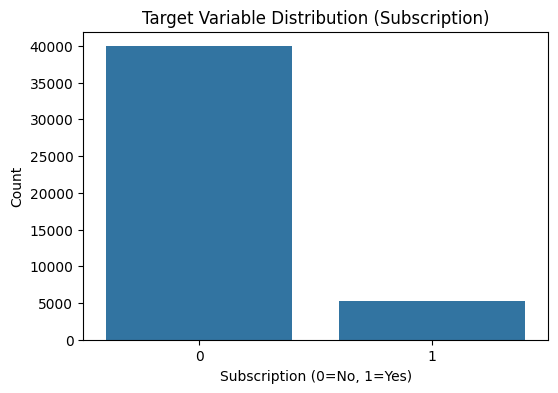

In [42]:
# Step 4: Exploratory Data Analysis (EDA)
# Target Variable Distribution
plt.figure(figsize=(6,4))
sns.countplot(x='y', data=df)
plt.title('Target Variable Distribution (Subscription)')
plt.xlabel('Subscription (0=No, 1=Yes)')
plt.ylabel('Count')
plt.show()



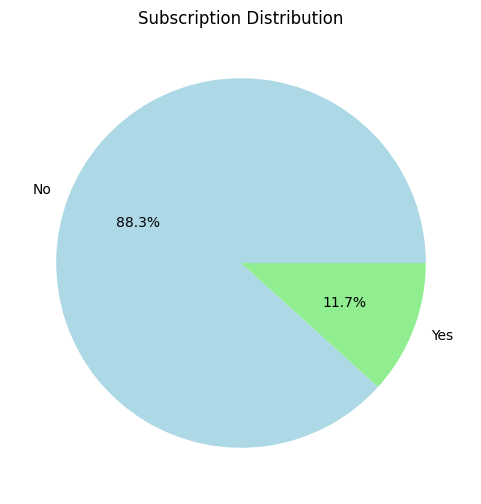

In [43]:
# Pie Chart for Target Variable
plt.figure(figsize=(6,6))
df['y'].value_counts().plot.pie(autopct='%1.1f%%', colors=['lightblue','lightgreen'], labels=['No','Yes'])
plt.title('Subscription Distribution')
plt.ylabel('')
plt.show()



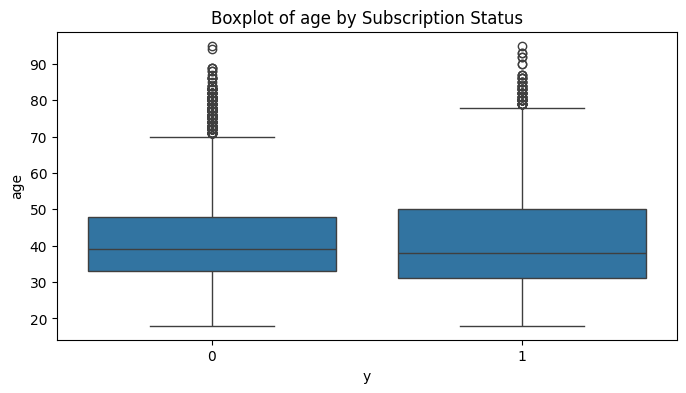

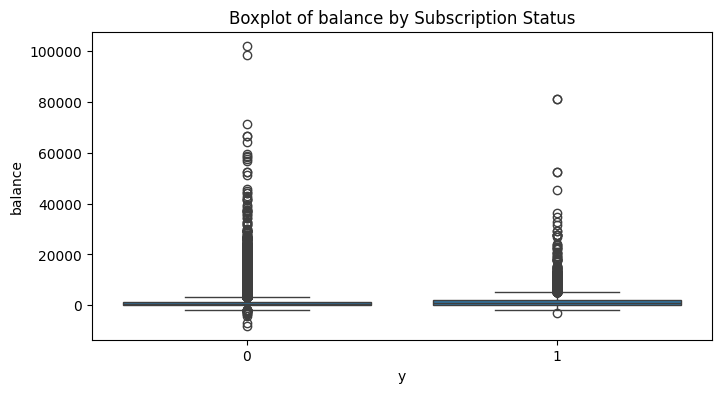

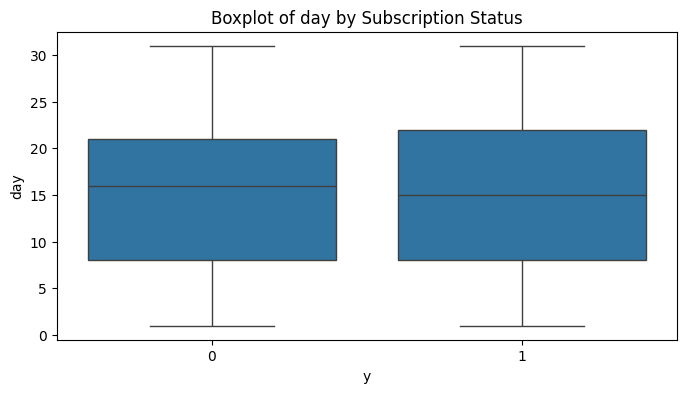

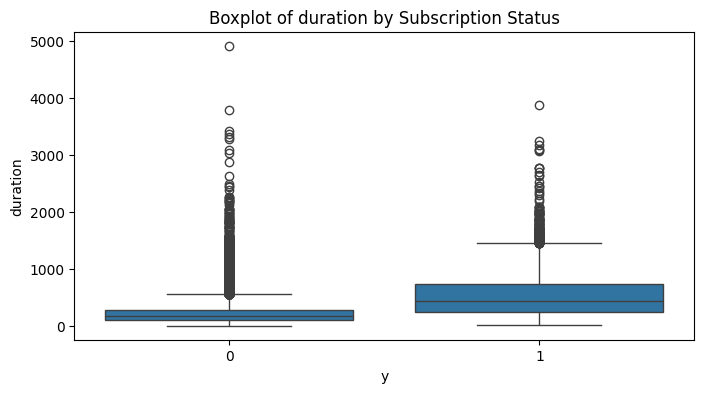

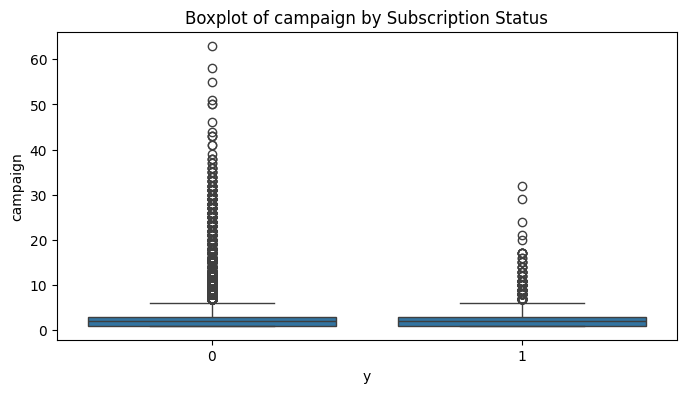

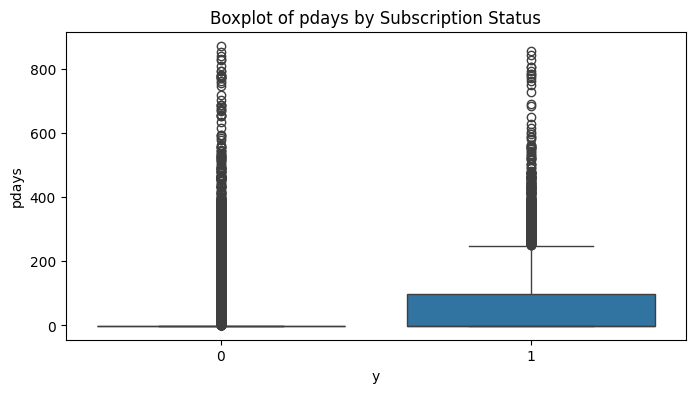

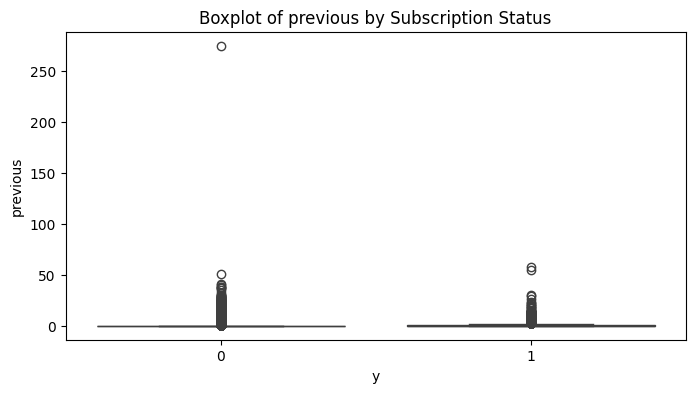

In [44]:
# Boxplot of Numerical Features
numerical_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
for col in numerical_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(data=df, x='y', y=col)
    plt.title(f'Boxplot of {col} by Subscription Status')
    plt.show()



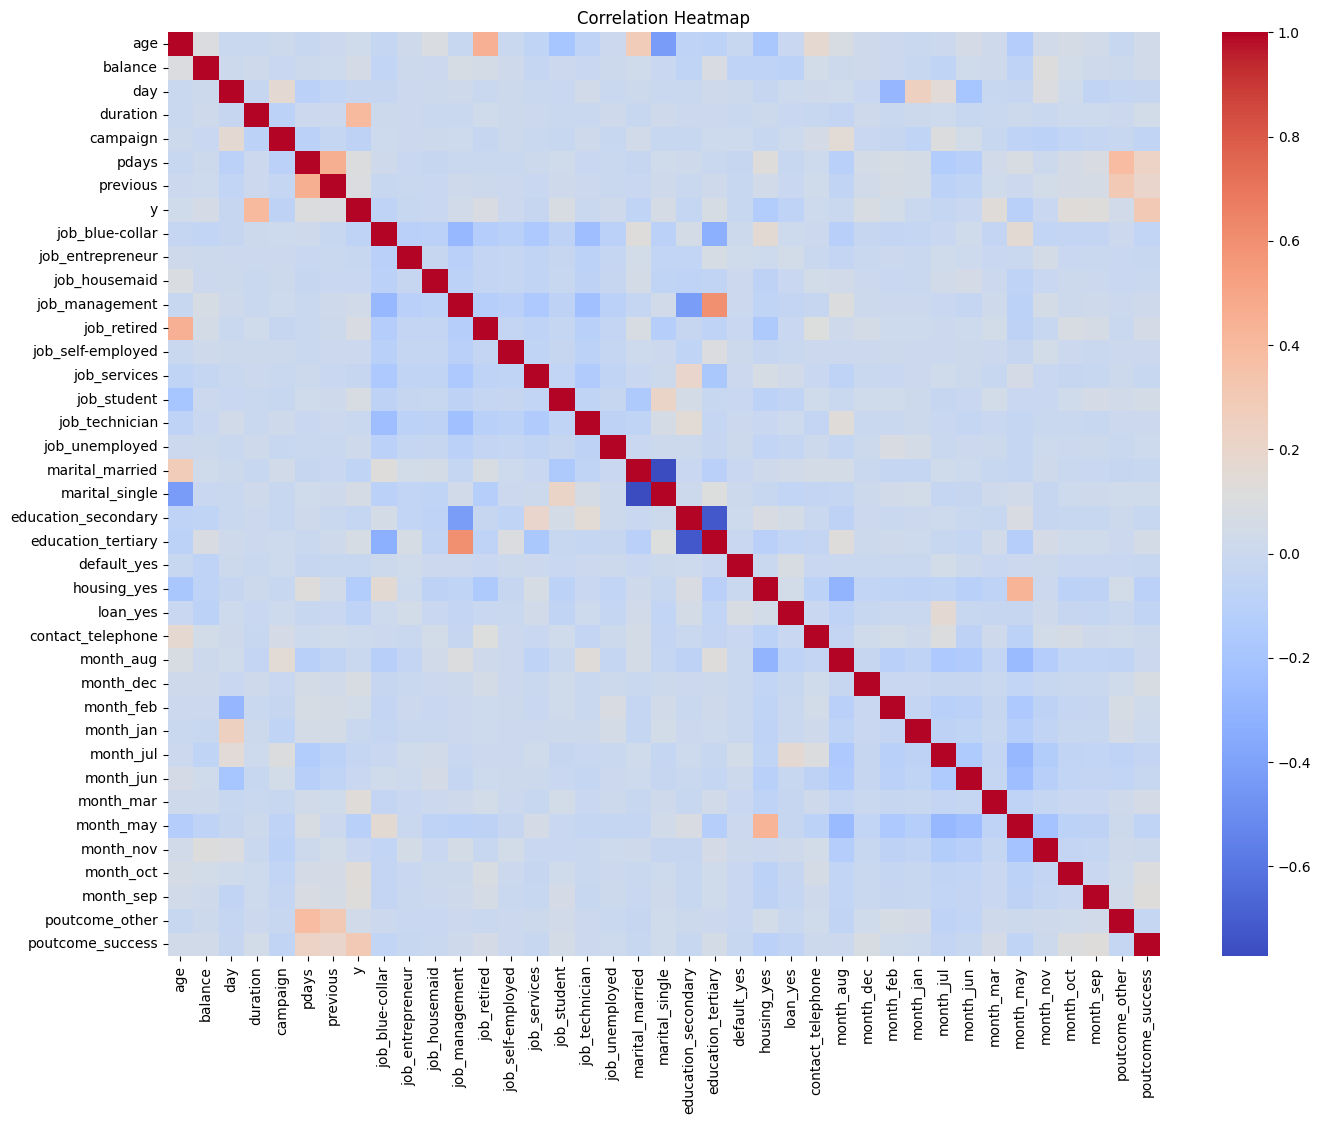

In [45]:
# Heatmap of Correlation
plt.figure(figsize=(16,12))
sns.heatmap(df_encoded.corr(), cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap')
plt.show()



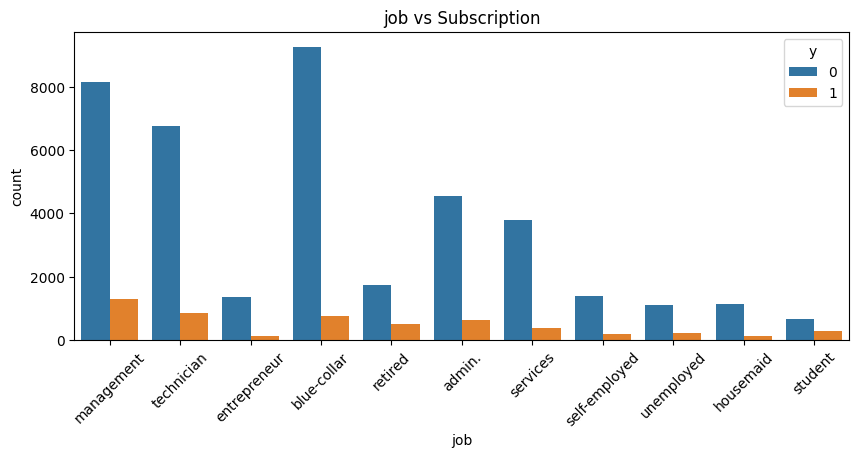

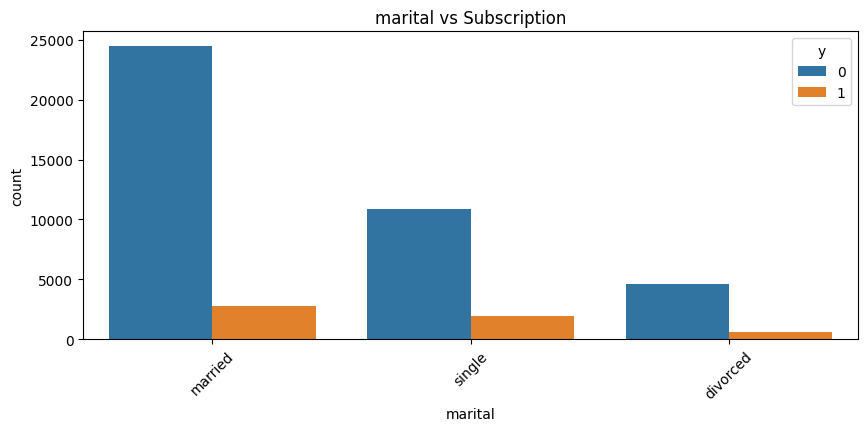

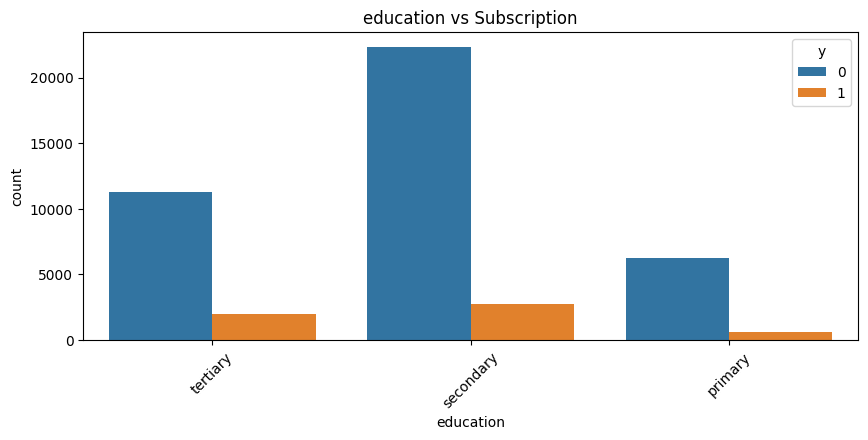

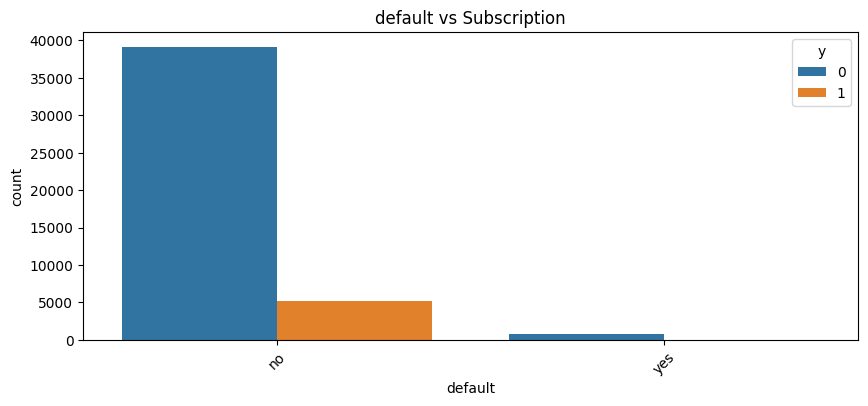

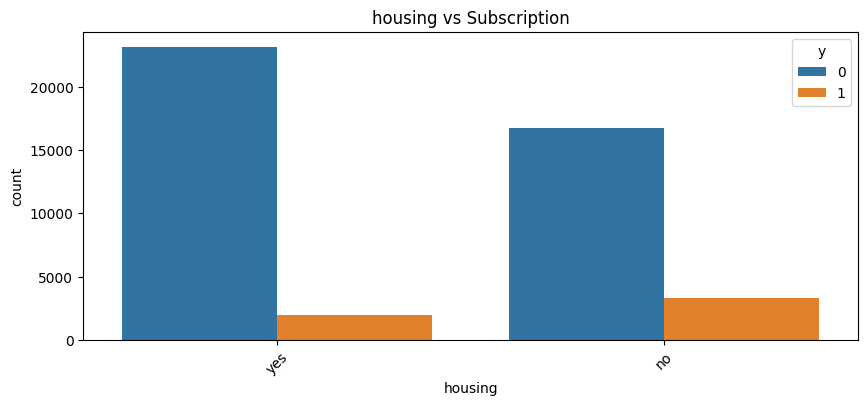

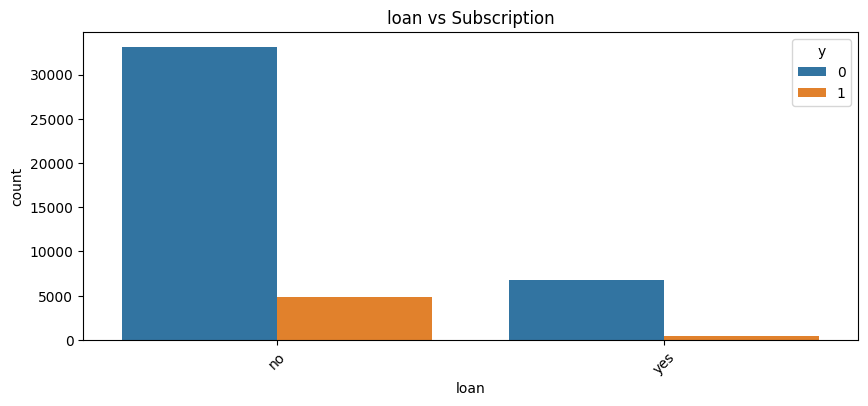

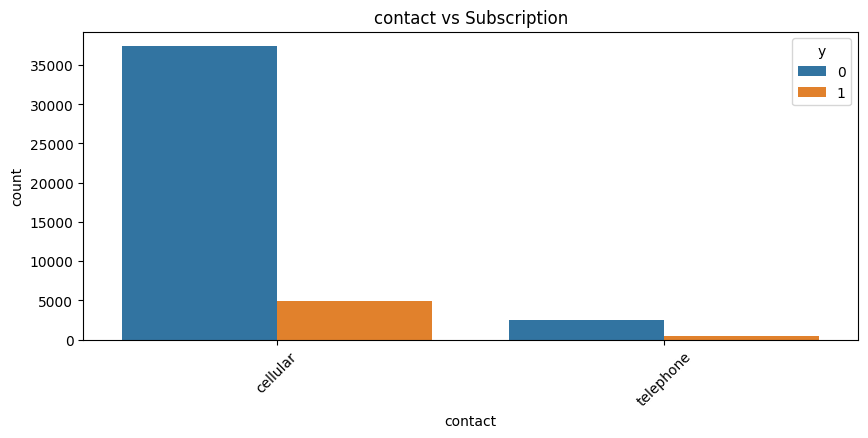

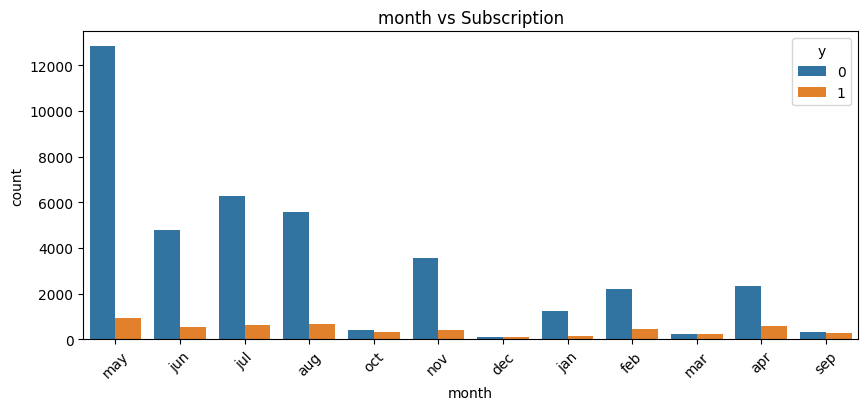

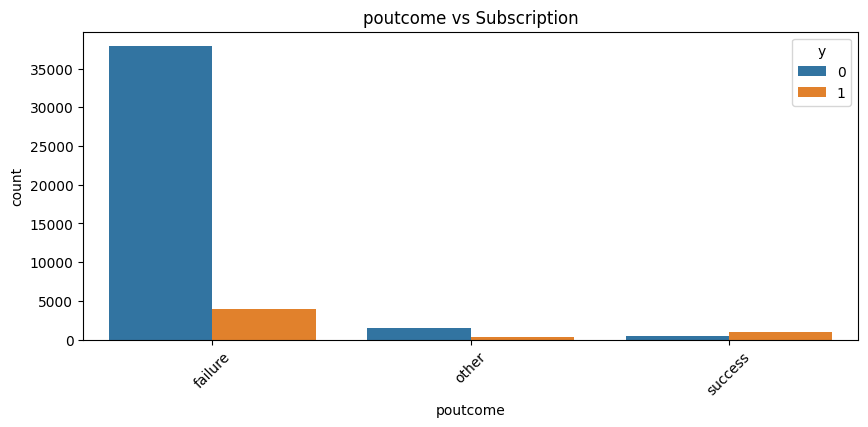

In [46]:
# Relationship Analysis: Categorical vs Target
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

for col in categorical_cols:
    plt.figure(figsize=(10,4))
    sns.countplot(data=df, x=col, hue='y')
    plt.title(f'{col} vs Subscription')
    plt.xticks(rotation=45)
    plt.show()

In [47]:
# Step 5: Feature Engineering
# 1. Create binary flags if feature originally had 'unknown' (before filling)
for col in ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']:
    df[f'{col}_unknown_flag'] = np.where(df[col] == 'unknown', 1, 0)

# 2. Create interaction terms (e.g., age * balance)
df['age_balance_interaction'] = df['age'] * df['balance']

# 3. Drop irrelevant features if any (none strictly mentioned, so keep all for now)

# Encode the Target Variable
df['y'] = df['y'].map({'yes': 1, 'no': 0})

In [48]:
# Step 6: Model Building
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [49]:
# Define Models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(),
    'Support Vector Machine': SVC(probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Bagging Classifier': BaggingClassifier(),
    'Extra Trees Classifier': ExtraTreesClassifier(),
    'Hist Gradient Boosting': HistGradientBoostingClassifier()
}



In [50]:
# Cross-Validation & Evaluation
results = []

for name, model in models.items():
    print(f"Training and Evaluating {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else y_pred

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    })


Training and Evaluating Logistic Regression...
Training and Evaluating Decision Tree...
Training and Evaluating Random Forest...
Training and Evaluating XGBoost...
Training and Evaluating LightGBM...
[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1039
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327
Training and Evaluating Support Vector Machine...
Training and Evaluating K-Nearest Neighbors...
Training and Evaluating Gradient Boosting...
Training and Evaluating AdaBoost...
Training and Evaluating Bagging Classifier...
Training and Evalua

In [51]:
# Step 7: Model Comparison and Evaluation
# Model Performance Summary
results_df = pd.DataFrame(results).sort_values(by="F1 Score", ascending=False)
print("\nModel Performance Summary:\n")
print(results_df)


Model Performance Summary:

                     Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
11  Hist Gradient Boosting  0.907553   0.648000  0.459357  0.537611  0.925618
3                  XGBoost  0.904235   0.620000  0.468809  0.533907  0.922421
4                 LightGBM  0.905673   0.637584  0.448960  0.526900  0.925140
2            Random Forest  0.904567   0.653543  0.392250  0.490254  0.918328
7        Gradient Boosting  0.904899   0.659677  0.386578  0.487485  0.916534
9       Bagging Classifier  0.897711   0.597651  0.384688  0.468085  0.879404
10  Extra Trees Classifier  0.901139   0.647482  0.340265  0.446097  0.904820
1            Decision Tree  0.864315   0.425682  0.457467  0.441002  0.687844
0      Logistic Regression  0.899259   0.634369  0.327977  0.432399  0.900597
5   Support Vector Machine  0.900807   0.672377  0.296786  0.411803  0.883795
6      K-Nearest Neighbors  0.892624   0.575916  0.311909  0.404660  0.803630
8                 AdaBoost  0.89561

In [52]:

# Select Best Model
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]
print(f"\n✅ Best Performing Model: {best_model_name}")# Save Best Model
# best_model_name = results_df.iloc[0]['Model']
# best_model = models[best_model_name]
# joblib.dump(best_model, f"{best_model_name.replace(' ', '_').lower()}_model.pkl")
# print(f"\n✅ Best model '{best_model_name}' saved successfully as a .pkl file.")


✅ Best Performing Model: Hist Gradient Boosting


In [53]:
# Save Best Model
joblib.dump(best_model, f"{best_model_name.replace(' ', '_').lower()}_model.pkl")
print(f"✅ Model saved successfully as {best_model_name.replace(' ', '_').lower()}_model.pkl")

✅ Model saved successfully as hist_gradient_boosting_model.pkl



Confusion Matrix for Best Model: Hist Gradient Boosting


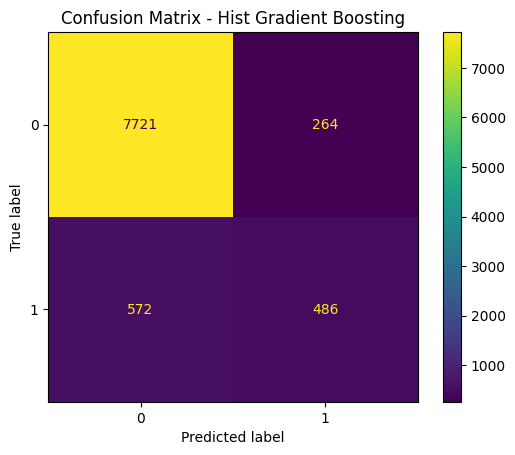

In [54]:
# Analyze Confusion Matrix for Best Model
print(f"\nConfusion Matrix for Best Model: {best_model_name}")
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
plt.title(f"Confusion Matrix - {best_model_name}")
plt.show()

In [55]:
# Print Classification Report
print("\nClassification Report for Best Model:\n")
print(classification_report(y_test, best_model.predict(X_test)))


Classification Report for Best Model:

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      7985
           1       0.65      0.46      0.54      1058

    accuracy                           0.91      9043
   macro avg       0.79      0.71      0.74      9043
weighted avg       0.90      0.91      0.90      9043



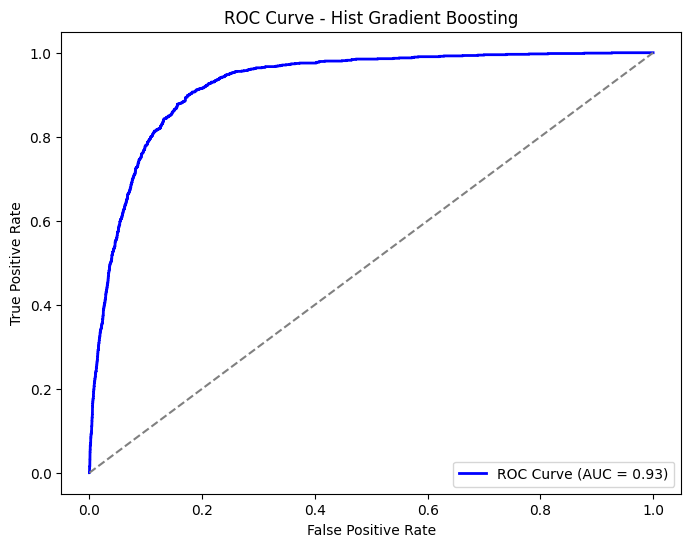

In [56]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f"ROC Curve - {best_model_name}")
plt.legend(loc="lower right")
plt.show()
